In [ ]:
#@title Init
!pip install CoolProp matplotlib numpy
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from CoolProp.CoolProp import PropsSI



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 10.6 MB/s eta 0:00:00


In [ ]:
# Define pressure in Pa (absolute)
P = (50 + 1.01325) * 1e5  # 18 barg converted to Pa absolute
T = 15 + 273.15

# Get saturation temperature for a liquid
T_sat = CP.PropsSI('T', 'P', P, 'Q', 0, 'CO2') - 273.15  # in Celsius
P_sat = CP.PropsSI('P', 'T', T, 'Q', 0, 'CO2') - 273.15  # in Celsius

H_sat_0 = CP.PropsSI('Hmass', 'T', T, 'Q', 0, 'CO2')/3600  # liquid -> J/kg / 3600, means that if you multiply this number with kg/h you get J/s = Watt, so this is essentiall watt/ (kg/h)
H_sat_1 = CP.PropsSI('Hmass', 'T', T, 'Q', 1, 'CO2')/3600  # gas -> not needed

print(f"Saturation temperature at {P/1e5:.2f} bara: {T_sat:.2f} °C")

Saturation temperature at 51.01 bara: 15.12 °C


In [ ]:
#!/usr/bin/env python3
#@title Enthalpy table
"""
This script computes the specific enthalpy of CO₂ for a set of temperatures
and pressures using CoolProp, converts the result to Wh/kg, and produces a table image.

Temperatures (°C): 5, 15, 25, 50, 60, 80
Pressures (bar): 20, 25, 40, 60, 80, 100

The conversion is: h (Wh/kg) = h (J/kg) / 3600.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

# Define the conditions:
temps_C = np.array([-35, -28, -20, 5, 15, 25, 50, 60, 80, 90, 160])         # Temperatures in °C
pressures_bar = np.array([18, 20, 25, 40, 60, 80, 100])   # Pressures in barg]a

# Prepare a list to hold computed enthalpy values (Wh/kg)
data = []
for T_C in temps_C:
    T_K = T_C + 273.15  # convert °C to Kelvin
    row = []
    for P_bar in pressures_bar:
        P_Pa = P_bar * 1e5  # convert bar to Pa (1 bar = 1e5 Pa)
        try:
            # Compute specific enthalpy in J/kg using CoolProp for CO2
            h_Jperkg = PropsSI('H', 'T', T_K, 'P', P_Pa, 'CO2')
        except Exception as e:
            h_Jperkg = np.nan
            print(f"Error for T={T_K} K, P={P_Pa} Pa: {e}")
        # Convert J/kg to Wh/kg (1 Wh = 3600 J)
        h_Whperkg = h_Jperkg / 3600.0
        row.append(h_Whperkg)
    data.append(row)

# Create a DataFrame for the table:
df = pd.DataFrame(data,
                  index=[f"{t}°C" for t in temps_C],
                  columns=[f"{p} bar" for p in pressures_bar])

# Print the table in the console:
print("CO2 Specific Enthalpy (Wh/kg):")
print(df.to_string(float_format=lambda x: f"{x:7.2f}"))


# Create a matplotlib figure to display the table as an image:
"""
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=np.round(df.values, 2),
                 rowLabels=df.index,
                 colLabels=df.columns,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("CO2 Specific Enthalpy (Wh/kg)", fontsize=14)
plt.tight_layout()
"""

# Save the figure as an image (optional)

"""
plt.savefig("CO2_Enthalpy_Table.png", dpi=300)
plt.show()
"""



CO2 Specific Enthalpy (Wh/kg):
       18 bar  20 bar  25 bar  40 bar  60 bar  80 bar  100 bar
-35°C   34.19   34.20   34.21   34.26   34.34   34.42    34.53
-28°C   38.19   38.19   38.19   38.19   38.22   38.27    38.33
-20°C  122.38   42.90   42.88   42.81   42.76   42.74    42.74
5°C    130.08  129.30  127.19   59.01   58.29   57.77    57.39
15°C   132.95  132.26  130.43  123.66   65.87   64.69    63.90
25°C   135.75  135.13  133.51  127.85  115.61   73.07    71.22
50°C   142.61  142.12  140.86  136.75  130.16  121.21   106.69
60°C   145.32  144.87  143.72  140.01  134.29  127.26   118.06
80°C   150.74  150.35  149.36  146.25  141.70  136.58   130.79
90°C   153.45  153.09  152.17  149.29  145.15  140.61   135.64
160°C  172.67  172.43  171.82  169.97  167.47  164.91   162.32


'\nplt.savefig("CO2_Enthalpy_Table.png", dpi=300)\nplt.show()\n'

In [ ]:
#!/usr/bin/env python3
#@title Subcooling
"""
This script uses CoolProp to calculate the required subcooling for cryogenic CO₂
to achieve an NPSHa of 3 m when pumping from a saturated state at -20°C.
It then computes the enthalpy difference (in Wh/kg) between the saturated state
and the subcooled state at the pump inlet pressure.

Assumptions:
- CO₂ is initially at -20°C and saturated.
- The pump inlet pressure is the saturation pressure at -20°C.
- NPSHa is given by (P_inlet - P_sat(T))/(rho(T)*g).
- We require NPSHa ≈ 3 m.
- g = 9.81 m/s².
- Enthalpy difference (in J/kg) is converted to Wh/kg by dividing by 3600.
"""

import numpy as np
from scipy.optimize import fsolve
from CoolProp.CoolProp import PropsSI

# Constants
g = 9.81  # gravitational acceleration, m/s²

# ----------------------------
# 1. Define initial (saturated) state at -20°C
# ----------------------------
T_initial_C = -20.0
T_initial = T_initial_C + 273.15  # convert °C to Kelvin
NPSHr = 5

# For a saturated liquid at -20°C, we can get the saturation pressure:
P_inlet = PropsSI('P', 'T', T_initial, 'Q', 0, 'CO2')  # in Pa
print("Initial State (saturated at -20°C):")
print("  T_initial = {:.2f} K ({:.2f} °C)".format(T_initial, T_initial_C))
print("  P_inlet (saturation pressure) = {:.2f} bar".format(P_inlet/1e5))

# ----------------------------
# 2. Define a function for the available NPSH as a function of temperature T
# ----------------------------
def npsh_residual(T):
    """
    For a given subcooled temperature T (in Kelvin), compute:

      NPSHa = (P_inlet - P_sat(T)) / (rho(T) * g)

    where P_sat(T) and rho(T) are the saturation pressure and density of CO2 at T.
    (We assume that if the liquid is subcooled, its "available" vapor pressure is that
    of the saturated liquid at that T.)

    We want NPSHa to equal 3 m.
    """
    P_sat_T = PropsSI('P', 'T', T, 'Q', 0, 'CO2')  # saturation pressure at T (Pa)
    rho_T   = PropsSI('D', 'T', T, 'Q', 0, 'CO2')  # density of saturated liquid at T (kg/m³)
    NPSHa = (P_inlet - P_sat_T) / (rho_T * g)
    return NPSHa - NPSHr

# ----------------------------
# 3. Solve for the subcooled temperature T_target (in Kelvin) such that NPSHa = 3 m
# ----------------------------
# We expect T_target to be below T_initial, so we choose an initial guess a few degrees lower.
T_guess = T_initial - 3.0  # for example, guess a 3 K subcooling
T_target = fsolve(npsh_residual, T_guess)[0]
subcooling = T_initial - T_target

# Verify NPSHa at the found temperature:
P_sat_target = PropsSI('P', 'T', T_target, 'Q', 0, 'CO2')
rho_target   = PropsSI('D', 'T', T_target, 'Q', 0, 'CO2')
NPSHa_target = (P_inlet - P_sat_target) / (rho_target * g)

print("\nSubcooling Calculation:")
print("  T_target = {:.2f} K ({:.2f} °C)".format(T_target, T_target - 273.15))
print("  Required subcooling = {:.2f} K".format(subcooling))
print("  NPSHa at T_target = {:.2f} m".format(NPSHa_target))
print("  NPSHr target= {:.2f} m".format(NPSHr))

# ----------------------------
# 4. Compute the enthalpy difference between the two states
# ----------------------------
# For the saturated state at -20°C:
h_saturated = PropsSI('H', 'T', T_initial, 'Q', 0, 'CO2')  # in J/kg

# For the subcooled state, we assume the pressure is maintained at P_inlet.
# We specify T_target and P_inlet (which is higher than the saturation pressure at T_target).
h_subcooled = PropsSI('H', 'T', T_target, 'P', P_inlet, 'CO2')  # in J/kg

delta_h_Jperkg = h_saturated - h_subcooled
delta_h_Whperkg = delta_h_Jperkg / 3600.0

print("\nEnthalpy Difference Calculation:")
print("  Enthalpy at saturated state (-20°C): {:.2f} J/kg".format(h_saturated))
print("  Enthalpy at subcooled state (T_target): {:.2f} J/kg".format(h_subcooled))
print("  Enthalpy difference: {:.2f} J/kg = {:.2f} Wh/kg".format(delta_h_Jperkg, delta_h_Whperkg))

# ----------------------------
# 5. Summary
# ----------------------------
print("\nSummary:")
print("To achieve an NPSHa of abou {:.2f} m".format(NPSHr))
print("  - The liquid must be subcooled by approximately {:.2f} °C (i.e. from -20°C to {:.2f} °C).".format(
    subcooling, T_target - 273.15))
print("  - The corresponding enthalpy removal is approximately {:.2f} Wh/kg.".format(delta_h_Whperkg))


Initial State (saturated at -20°C):
  T_initial = 253.15 K (-20.00 °C)
  P_inlet (saturation pressure) = 19.70 bar

Subcooling Calculation:
  T_target = 252.31 K (-20.84 °C)
  Required subcooling = 0.84 K
  NPSHa at T_target = 5.00 m
  NPSHr target= 5.00 m

Enthalpy Difference Calculation:
  Enthalpy at saturated state (-20°C): 154448.33 J/kg
  Enthalpy at subcooled state (T_target): 152624.35 J/kg
  Enthalpy difference: 1823.98 J/kg = 0.51 Wh/kg

Summary:
To achieve an NPSHa of abou 5.00 m
  - The liquid must be subcooled by approximately 0.84 °C (i.e. from -20°C to -20.84 °C).
  - The corresponding enthalpy removal is approximately 0.51 Wh/kg.


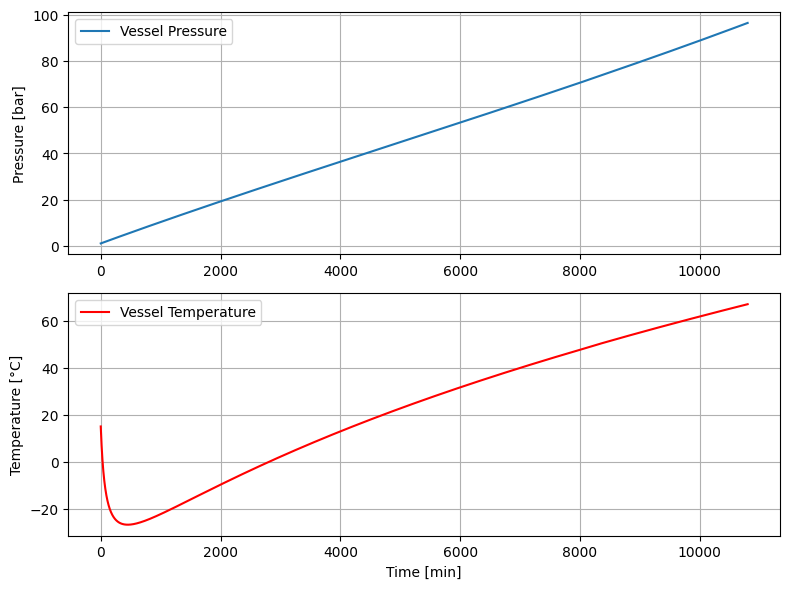

In [ ]:
#@title Reactor temperature, using simple close in goal seek

#import numpy as np
#import CoolProp.CoolProp as CP
#import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# User Inputs / Constants
# ------------------------------------------------------------------------------
# Vessel
V = 1.5  # Vessel volume [m³] (1500 liters)
T_vessel_init = 15.0 + 273.15  # Ambient temperature ~15°C in K
P_vessel_init = 1e5      # Ambient pressure: 1 bar absolute in Pa

# Instead of starting with an empty vessel, calculate initial mass as:
rho_init = CP.PropsSI("D", "T", T_vessel_init, "P", P_vessel_init, "CO2")
m_CO2_init = rho_init * V

# Then compute the specific internal energy at these conditions:
u_init = CP.PropsSI("UMASS", "T", T_vessel_init, "P", P_vessel_init, "CO2")
U = m_CO2_init * u_init  # Total initial internal energy




# CO2 Inlet
P_in_CO2  = 101e5  # Inlet pressure [Pa] (100 barg = 101 bar abs)
T_in_CO2  = 70+273.15 # Inlet temperature [K], ~85°C
m_dot_CO2 = 120.0 / 3600.0  # Mass flow rate [kg/s] (120 kg/h)

# Simulation
dt          = 1.0    # Time step [s]
total_time  = 3*3600.0  # Total simulation time [s]
n_steps     = int(total_time / dt)

# ------------------------------------------------------------------------------
# Helper Function: Solve for T given U, m_CO2, V
# ------------------------------------------------------------------------------
def solve_temperature_for_internal_energy(U, m, V, T_low=180.0, T_high=600.0, tol=1e-3):
    """
    Solve for T_new using a simple bisection such that:
        U = m * u_CO2(T_new)
    where u_CO2(T_new) is the specific internal energy from CoolProp at density = m/V.

    Returns T_new [K].
    """
    if m < 1e-9:
        # If there's effectively no CO2, return some default T or 0
        return 288.15  # arbitrary fallback if vessel is "empty"

    # Bisection bracket
    for _ in range(50):  # Limit iterations
        T_mid = 0.5 * (T_low + T_high)

        # Calculate internal energy for T_mid
        rho_mid = m / V
        try:
            u_mid = CP.PropsSI("UMASS", "D", rho_mid, "T", T_mid, "CO2")  # [J/kg]
        except:
            # If CoolProp fails for some reason, break early or adjust bracket
            break

        U_mid = m * u_mid

        if (U_mid - U) > 0:
            # We need a lower T to reduce internal energy
            T_high = T_mid
        else:
            # We need a higher T to increase internal energy
            T_low = T_mid

        if abs(U_mid - U) < tol:
            return T_mid

    return T_mid  # Return best guess after iterations

# ------------------------------------------------------------------------------
# Initialization
# ------------------------------------------------------------------------------
time_list = []
T_list    = []
P_list    = []

# Initial vessel state (internal energy of CO2)
# If you want to start with some initial CO2, you can set m_CO2_init != 0
m_CO2 = m_CO2_init

# For nonzero initial CO2:
rho_init_CO2 = m_CO2 / V if m_CO2 > 0 else 1e-9
try:
    u_init_CO2 = CP.PropsSI("UMASS", "D", rho_init_CO2, "T", T_vessel_init, "CO2")
except:
    u_init_CO2 = 0.0

U = m_CO2 * u_init_CO2  # total internal energy of CO2 in vessel

T = T_vessel_init
P = P_vessel_init

# ------------------------------------------------------------------------------
# Main Loop
# ------------------------------------------------------------------------------
for step in range(n_steps):
    t_current = step * dt

    # Store data
    time_list.append(t_current)
    T_list.append(T - 273.15)  # Convert to °C for logging
    P_list.append(P / 1e5)     # Convert to bara

    # --- 1) Calculate how much CO2 enters in this timestep ---
    dm_CO2 = m_dot_CO2 * dt

    # If no inflow needed or the vessel is at final condition, you could skip
    if dm_CO2 <= 0:
        continue

    # --- 2) Isenthalpic expansion from (P_in_CO2, T_in_CO2) down to vessel P ---
    # Enthalpy of inlet CO2 at (P_in_CO2, T_in_CO2)
    h_inlet = CP.PropsSI("H", "P", P_in_CO2, "T", T_in_CO2, "CO2")  # [J/kg]

    # Temperature of CO2 after isenthalpic expansion to vessel P
    # (assuming vessel P < P_in_CO2; if P >= P_in_CO2, no expansion cooling)
    if P < P_in_CO2:
        try:
            T_inlet_isent = CP.PropsSI("T", "P", P, "H", h_inlet, "CO2")
        except:
            # If out of range for some reason, revert to simpler approach
            T_inlet_isent = T_in_CO2
    else:
        T_inlet_isent = T_in_CO2

    # The internal energy of the incoming CO2 at (P, T_inlet_isent)
    u_inlet = CP.PropsSI("UMASS", "P", P, "T", T_inlet_isent, "CO2")  # [J/kg]

    # --- 3) Update total internal energy in the vessel ---
    U += dm_CO2 * u_inlet

    # --- 4) Update mass of CO2 in vessel ---
    m_CO2 += dm_CO2

    # --- 5) Solve for new vessel temperature via internal energy ---
    T = solve_temperature_for_internal_energy(U, m_CO2, V)

    # --- 6) Determine new vessel pressure from updated T, m_CO2, and V ---
    rho = m_CO2 / V
    try:
        P = CP.PropsSI("P", "D", rho, "T", T, "CO2")
    except:
        # If there's a region where CoolProp can't solve, you might handle it here
        pass

# ------------------------------------------------------------------------------
# Plot Results
# ------------------------------------------------------------------------------

plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(time_list, P_list, label="Vessel Pressure")
plt.ylabel("Pressure [bar]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_list, T_list, 'r', label="Vessel Temperature")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


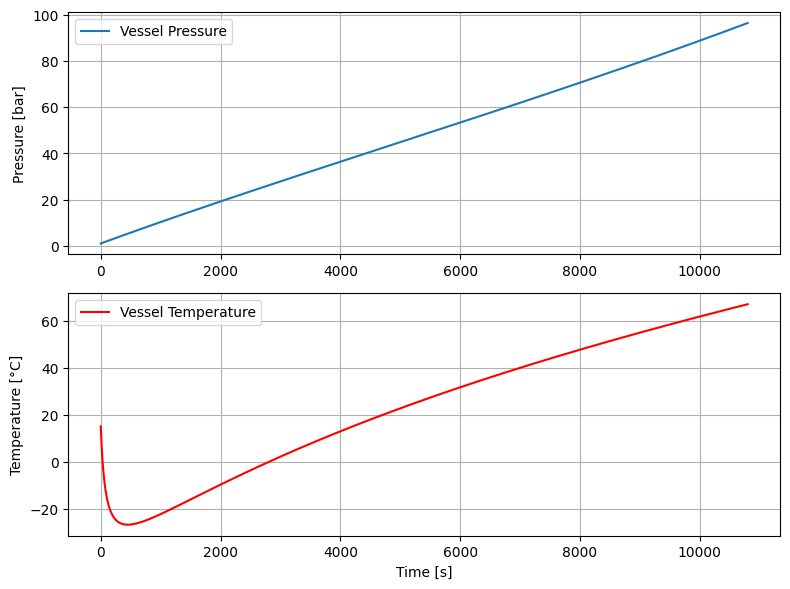

"\n# ------------------------------------------------------------------------------\n# 6. Plotting Results\n# ------------------------------------------------------------------------------\nplt.figure(figsize=(12,5))\n\nplt.subplot(1,2,1)\nplt.plot(time, T_arr - 273.15, 'b-')\nplt.xlabel('Time (s)')\nplt.ylabel('Temperature (°C)')\nplt.title('Vessel Temperature vs. Time')\nplt.grid(True)\n\nplt.subplot(1,2,2)\nplt.plot(time/3600, P_arr/1e5, 'r-')\nplt.xlabel('Time (hours)')\nplt.ylabel('Pressure (bar)')\nplt.title('Vessel Pressure vs. Time')\nplt.grid(True)\n\nplt.tight_layout()\nplt.show()\n"

In [ ]:
#@title Reactor temperature, using fsolve
#!/usr/bin/env python3
"""
Corrected model for a throttling injection process.
The vessel is pre-filled with CO2 at ambient conditions (1 bar, ~15°C)
to mimic air’s thermal mass. CO2 is injected at 100 barg (101 bar abs) and 85°C.
However, before being added to the vessel the CO2 expands isenthalpically
to the current vessel pressure (a throttling process), so its internal energy is lower.
CoolProp is used for CO2 thermodynamic properties.
"""

#import numpy as np
#import matplotlib.pyplot as plt
#from scipy.optimize import fsolve
#from CoolProp.CoolProp import PropsSI

# ------------------------------------------------------------------------------
# 1. Vessel Initial Conditions (Pre-filled with CO2 at ambient conditions)
# ------------------------------------------------------------------------------
V = 1.5                  # Vessel volume in m³ (1500 liters)
T_vessel_init = 15.0 + 273.15  # Ambient temperature ~15°C in K
P_vessel_init = 1e5      # Ambient pressure: 1 bar absolute in Pa

# Pre-fill vessel with CO2 at ambient conditions (to represent the air's thermal mass)
rho_init = PropsSI('D', 'T', T_vessel_init, 'P', P_vessel_init, 'CO2')
m0 = rho_init * V        # Initial mass [kg]
u0 = PropsSI('UMASS', 'T', T_vessel_init, 'P', P_vessel_init, 'CO2')  # [J/kg]
U0 = m0 * u0             # Total initial internal energy [J]

# ------------------------------------------------------------------------------
# 2. Injection (CO2) Parameters
# ------------------------------------------------------------------------------
m_dot = 120/3600.0       # Mass flow rate in kg/s (120 kg/h)
T_in = 70.0 + 273.15     # Inlet temperature in K (85°C)
P_in = (100 + 1)*1e5     # Inlet pressure in Pa (100 barg -> 101 bar abs)

# Compute the inlet enthalpy at injection conditions
h_in = PropsSI('H', 'T', T_in, 'P', P_in, 'CO2')

# ------------------------------------------------------------------------------
# 3. Time Discretization
# ------------------------------------------------------------------------------
dt = 1.0              # Time step in seconds
t_final = 3*3600.0    # Total simulation time: 3 hours
N = int(t_final/dt) + 1
time = np.linspace(0, t_final, N)

# Preallocate arrays for results
T_arr = np.zeros(N)  # Temperature [K]
P_arr = np.zeros(N)  # Pressure [Pa]
m_arr = np.zeros(N)  # Total mass [kg]
U_arr = np.zeros(N)  # Total internal energy [J]

# Set initial state
T_arr[0] = T_vessel_init
P_arr[0] = P_vessel_init
m_arr[0] = m0
U_arr[0] = U0

# ------------------------------------------------------------------------------
# 4. Helper Function: Solve for Temperature from Energy Balance
# ------------------------------------------------------------------------------
def energy_residual(T, e_target, rho):
    """
    Returns the difference between the specific internal energy at temperature T and e_target.
    """
    u_val = PropsSI('UMASS', 'T', T, 'D', rho, 'CO2')
    return u_val - e_target

# ------------------------------------------------------------------------------
# 5. Main Simulation Loop (Throttling Injection)
# ------------------------------------------------------------------------------
T_current = T_vessel_init

for i in range(1, N):
    # Current vessel state
    P_current = P_arr[i-1]

    # --- 1) Compute the injected CO2 state after throttling ---
    # In a throttling process, the CO2 enters isenthalpically.
    # If vessel pressure is below injection pressure, the CO2 expands.
    if P_current < P_in:
        # Wrap the PropsSI call in a try-except block to handle potential errors
        try:
            T_injected = PropsSI("T", "P", P_current, "H", h_in, "CO2")
        except ValueError:
            # If CoolProp fails, use the previous temperature as an approximation
            # or implement a more sophisticated fallback strategy.
            T_injected = T_arr[i-1] if i > 0 else T_in #If this is the first step, use T_in

            #Print a warning message
            print(f"Warning: CoolProp failed at step {i}, temp_reactor: {T_new-273.15:.1f}, temp_inj: {T_injected-273.15:.1f}, pres: {P_current/1e5:.1f}. Using previous temperature: {T_arr[i-1]-273.15:.1f}.")

    else:
        # If vessel pressure is very high (unlikely here), no expansion is needed.
        T_injected = T_in

    # Compute the injected internal energy at vessel pressure and T_injected.
    u_injected = PropsSI("UMASS", "P", P_current, "T", T_injected, "CO2")

    # --- 2) Update the total mass and energy in the vessel ---
    dm = m_dot * dt
    m_new = m_arr[i-1] + dm
    # Note: For throttling, the energy added is m_dot * u_injected (not m_dot * h_in)
    deltaU = dm * u_injected
    U_new = U_arr[i-1] + deltaU

    # --- 3) Update the vessel state via energy balance ---
    rho_new = m_new / V         # New density
    e_target = U_new / m_new      # Target specific internal energy

    # Solve for T_new such that u(T_new, rho_new) = e_target.
    T_new = fsolve(energy_residual, T_current, args=(e_target, rho_new))[0]
    # Determine new pressure using the equation of state
    P_new = PropsSI("P", "T", T_new, "D", rho_new, "CO2")

    # Save new state
    m_arr[i] = m_new
    U_arr[i] = U_new
    T_arr[i] = T_new
    P_arr[i] = P_new

    T_current = T_new  # Update for next iteration


    # ------------------------------------------------------------------------------
# Plot Results
# ------------------------------------------------------------------------------

plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(time, P_arr/1e5, label="Vessel Pressure")
plt.ylabel("Pressure [bar]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, T_arr - 273.15, 'r', label="Vessel Temperature")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


"""
# ------------------------------------------------------------------------------
# 6. Plotting Results
# ------------------------------------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(time, T_arr - 273.15, 'b-')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Vessel Temperature vs. Time')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(time/3600, P_arr/1e5, 'r-')
plt.xlabel('Time (hours)')
plt.ylabel('Pressure (bar)')
plt.title('Vessel Pressure vs. Time')
plt.grid(True)

plt.tight_layout()
plt.show()
"""

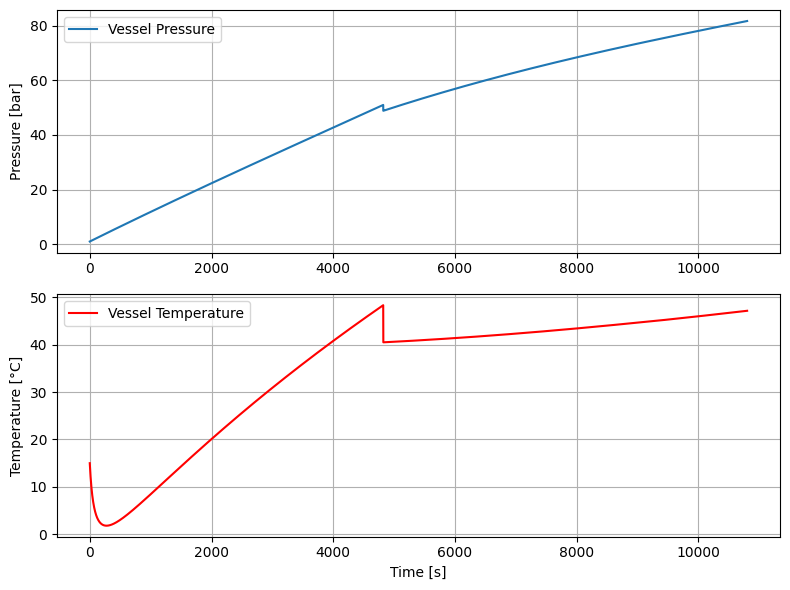

"\n# ------------------------------------------------------------------------------\n# 6. Plotting the Results\n# ------------------------------------------------------------------------------\nplt.figure(figsize=(12, 5))\nplt.subplot(1, 2, 1)\nplt.plot(time/3600, T_arr - 273.15, 'b-')\nplt.xlabel('Time (hours)')\nplt.ylabel('Temperature (°C)')\nplt.title('Reactor Temperature vs. Time')\nplt.grid(True)\n\nplt.subplot(1, 2, 2)\nplt.plot(time/3600, P_arr/1e5, 'r-')\nplt.xlabel('Time (hours)')\nplt.ylabel('Pressure (bar)')\nplt.title('Reactor Pressure vs. Time')\nplt.grid(True)\n\nplt.tight_layout()\nplt.show()\n"

In [ ]:
#@title Model Reactor, circulating water at 50bar
#!/usr/bin/env python3
"""
Model of a reactor where CO2 is injected into a 1500-liter vessel.
Before 50 bar, the reactor contains only CO2.
Once 50 bar is reached, 500 liters of water at 40°C (≈500 kg) is injected
and perfectly mixed with the CO2 (via an eductor) so that the energy is shared.
CoolProp is used for thermophysical properties.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from CoolProp.CoolProp import PropsSI

# ------------------------------------------------------------------------------
# 1. Parameters and Initial Conditions
# ------------------------------------------------------------------------------
# Reactor volumes (in m^3)
V_gas = 1.5           # Reactor vessel gas volume (1500 liters)
# Water: 500 liters (assume density ~1000 kg/m^3)
m_water = 500.0       # kg
T_water_init = 40.0 + 273.15  # 40°C in K

# Initial state of the reactor (assume pre-filled with CO2 at ambient conditions)
T_init = 15.0 + 273.15  # 15°C in K
P_init = 1e5          # 1 bar absolute in Pa

# We assume the reactor initially contains CO2 at these conditions (to mimic the thermal mass of air)
rho_init = PropsSI('D', 'T', T_init, 'P', P_init, 'CO2')
m_CO2_init = rho_init * V_gas  # kg
u_CO2_init = PropsSI('UMASS', 'T', T_init, 'P', P_init, 'CO2')
E_CO2_init = m_CO2_init * u_CO2_init  # Total CO2 internal energy [J]

# ------------------------------------------------------------------------------
# 2. CO2 Injection Parameters (Throttled Injection)
# ------------------------------------------------------------------------------
m_dot = 120 / 3600.0  # kg/s (120 kg/h)
T_in = 85.0 + 273.15  # Inlet temperature in K (85°C)
P_in = (100 + 1)*1e5  # Inlet pressure in Pa (100 barg -> 101 bar abs)
# Compute the inlet enthalpy at injection conditions
h_in = PropsSI('H', 'T', T_in, 'P', P_in, 'CO2')

# ------------------------------------------------------------------------------
# 3. Simulation Settings
# ------------------------------------------------------------------------------
dt = 1.0            # Time step (s)
t_final = 3 * 3600.0  # Total simulation time (3 hours)
N = int(t_final / dt) + 1
time = np.linspace(0, t_final, N)

# Preallocate arrays (store reactor temperature, pressure, and CO2 mass)
T_arr = np.zeros(N)   # Reactor temperature [K]
P_arr = np.zeros(N)   # Reactor pressure [Pa] (we use CO2 EOS for pressure)
m_CO2_arr = np.zeros(N)  # CO2 mass in reactor [kg]
E_CO2_arr = np.zeros(N)  # CO2 energy (only for the gas) [J]

# For the mixture, we also track the total energy (CO2 + water)
E_total_arr = np.zeros(N)

# Initial conditions
T_arr[0] = T_init
P_arr[0] = P_init
m_CO2_arr[0] = m_CO2_init
E_CO2_arr[0] = E_CO2_init
# Initially, before water injection, the total energy is just that of CO2.
E_total_arr[0] = E_CO2_init

# Flag to indicate water has been injected
water_injected = False

# ------------------------------------------------------------------------------
# 4. Helper Function: Residual for Mixture Energy Balance
# ------------------------------------------------------------------------------
def mixture_energy_residual(T, E_total, m_CO2, m_water, P_guess):
    """
    For a given trial temperature T, compute the difference between the sum of
    the internal energies (of CO2 and water) and the target total energy.

    For CO2, we use its density computed as m_CO2/V_gas.
    For water, we use properties at pressure P_guess (water is nearly incompressible).
    """
    rho_CO2 = m_CO2 / V_gas  # CO2 density (kg/m^3)
    u_CO2 = PropsSI("UMASS", "T", T, "D", rho_CO2, "CO2")
    u_water = PropsSI("UMASS", "T", T, "P", P_guess, "Water")
    E_mix = m_CO2 * u_CO2 + m_water * u_water
    return E_mix - E_total

# ------------------------------------------------------------------------------
# 5. Main Simulation Loop
# ------------------------------------------------------------------------------
T_current = T_init
m_CO2_current = m_CO2_init
E_CO2_current = E_CO2_init
E_total_current = E_CO2_current  # Before water injection

for i in range(1, N):
    # CO2 injection: mass increase in this time step
    dm = m_dot * dt

    # Compute throttled injection: the CO2 enters isenthalpically.
    # For throttling, we assume the CO2 expands from its high-pressure state to the current reactor pressure.
    if P_arr[i-1] < P_in:
      try:
        T_injected = PropsSI("T", "P", P_arr[i-1], "H", h_in, "CO2")
      except ValueError:
        # If CoolProp fails, use the previous temperature as an approximation
        # or implement a more sophisticated fallback strategy.
        T_injected = T_arr[i-1] if i > 0 else T_in

        #Print a warning message
        print(f"Warning: CoolProp failed at step {i}, temp_reactor: {T_new-273.15:.1f}, temp_inj: {T_injected-273.15:.1f}, pres: {P_arr[i-1]/1e5:.1f}. Using previous temperature: {T_arr[i-1]-273.15:.1f}.")
    else:
        T_injected = T_in
    u_injected = PropsSI("UMASS", "P", P_arr[i-1], "T", T_injected, "CO2")
    dE_injected = dm * u_injected


    # Update CO2 mass and energy (for CO2 part only)
    m_CO2_current += dm
    E_CO2_current += dE_injected

    # Update total energy: if water has been injected, include its contribution.
    if not water_injected and (P_arr[i-1] >= (50 + 1)*1e5):  # e.g., when reactor pressure reaches ~51 bar abs
        # At the moment of water injection, add water to the energy balance.
        water_injected = True
        # Compute water’s initial energy using its starting temperature
        u_water_init = PropsSI("UMASS", "T", T_water_init, "P", P_arr[i-1], "Water")
        E_water = m_water * u_water_init
        E_total_current += E_water  # Now the total energy is CO2 energy + water energy
    elif water_injected:
        # After water injection, we assume that the water is perfectly mixed.
        # Its energy will update along with the mixture temperature.
        # The only new energy input is from CO2 injection.
        E_total_current += dE_injected
    else:
        # Before water injection, total energy is just that of CO2.
        E_total_current += dE_injected

    # Store updated CO2 energy and mass (for tracking)
    m_CO2_arr[i] = m_CO2_current
    E_CO2_arr[i] = E_CO2_current

    # Now, determine the reactor (mixture) temperature.
    # If water has not been injected, use CO2 alone:
    if not water_injected:
        # For CO2 alone, we solve for T such that u_CO2(T, rho) = E_CO2_current / m_CO2_current.
        def res_CO2(T):
            rho_CO2 = m_CO2_current / V_gas
            return PropsSI("UMASS", "T", T, "D", rho_CO2, "CO2") - (E_CO2_current / m_CO2_current)
        T_new = fsolve(res_CO2, T_current)[0]
    else:
        # For the mixture, solve for T such that:
        # m_CO2 * u_CO2(T, rho_CO2) + m_water * u_water(T, P) = E_total_current.
        # We use the current reactor pressure as a guess for the water property.
        T_new = fsolve(mixture_energy_residual, T_current, args=(E_total_current, m_CO2_current, m_water, P_arr[i-1]))[0]

    T_current = T_new
    T_arr[i] = T_new

    # For the reactor pressure, we assume that the CO2 (being compressible) sets the pressure.
    # (In a more complex model the mixture EOS might be needed.)
    rho_CO2 = m_CO2_current / V_gas
    P_new = PropsSI("P", "T", T_new, "D", rho_CO2, "CO2")
    P_arr[i] = P_new

    E_total_arr[i] = E_total_current


    # ------------------------------------------------------------------------------
# Plot Results
# ------------------------------------------------------------------------------

plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(time, P_arr/1e5, label="Vessel Pressure")
plt.ylabel("Pressure [bar]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, T_arr - 273.15, 'r', label="Vessel Temperature")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

"""
# ------------------------------------------------------------------------------
# 6. Plotting the Results
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(time/3600, T_arr - 273.15, 'b-')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (°C)')
plt.title('Reactor Temperature vs. Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(time/3600, P_arr/1e5, 'r-')
plt.xlabel('Time (hours)')
plt.ylabel('Pressure (bar)')
plt.title('Reactor Pressure vs. Time')
plt.grid(True)

plt.tight_layout()
plt.show()
"""


In [ ]:
#@title small calculations
# Inputs for CO2 properties
fluid = 'CO2'
temperature = -20 + 273.15  # Convert temperature to Kelvin
pressure = 20 * 1e5  # Convert bar to Pascals

# Calculate densities for liquid and gaseous phases
density_liquid = CP.PropsSI('D', 'P', pressure, 'T', temperature, fluid, phase='liquid')
density_gas = CP.PropsSI('D', 'P', pressure, 'T', temperature, fluid, phase='gas')

print(f"Density of liquid CO2: {density_liquid} kg/m³")
print(f"Density of gaseous CO2: {density_gas} kg/m³")

#!pip install CoolProp matplotlib numpy
import CoolProp.CoolProp as CP
print(CP.PropsSI('D', 'T', 85+273.15, 'P', 100*1e5, 'CO2'))


H_100bar = CP.PropsSI('H', 'T', 170+273.15, 'P', 100*1e5, 'CO2')
H_80bar = CP.PropsSI('H', 'T', 170+273.15, 'P', 80*1e5, 'CO2')

print((H100_bar - H_80bar)/44) #kJ/kmol / g/mol = kg / 1000 = t


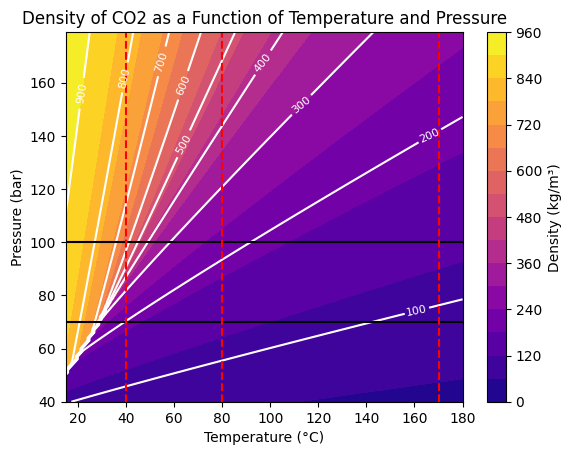

In [ ]:
#@title Density CO2 at T.P
#!pip install CoolProp matplotlib numpy
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt

# Define the ranges for temperature and pressure with specified steps
temperatures = np.arange(15 + 273.15, 181 + 273.15, 1)  # -40°C to 200°C in Kelvin, steps of 20
pressures = np.arange(40, 180, 1) * 1e5  # 1 bar to 150 bar in Pascals, steps of 10

# Create a grid of temperature and pressure values
T, P = np.meshgrid(temperatures, pressures)

# Calculate densities for each point on the grid
densities = np.vectorize(CP.PropsSI)('D', 'T', T, 'P', P, 'CO2')

# Create a contour plot with 'viridis' colormap
fig, ax = plt.subplots()
contour = ax.contourf(temperatures - 273.15, pressures / 1e5, densities, levels=15, cmap='plasma')

# Add contour lines for specific density values
contour_lines = ax.contour(temperatures - 273.15, pressures / 1e5, densities, levels=np.arange(100, 1000, 100), colors='white')
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f') # Label contour lines


# Add a horizontal line at yy bar
ax.axhline(y=100, color='black', linestyle='-')
ax.axhline(y=70,  color='black', linestyle='-')

# Add a vertical line at xx C
ax.axvline(x=170, color='red', linestyle='--')
ax.axvline(x=80, color='red', linestyle='--')
ax.axvline(x=40, color='red', linestyle='--')

# Add labels and title
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Pressure (bar)")
ax.set_title("Density of CO2 as a Function of Temperature and Pressure")

# Add a colorbar
cbar = fig.colorbar(contour)
cbar.set_label("Density (kg/m³)")

# Show the plot
plt.show()

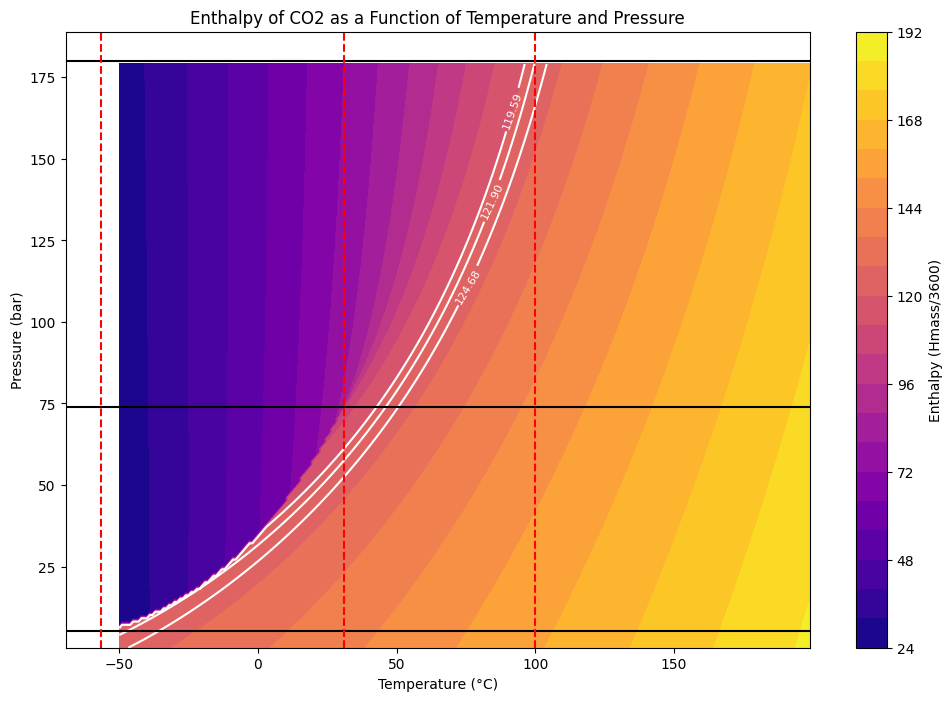

In [ ]:
#@title Constant enthalpy, dry ice line

#!pip install CoolProp matplotlib numpy
#import CoolProp.CoolProp as CP
#import numpy as np
#import matplotlib.pyplot as pl8





# ----------------------------
# 8. CO2 TRIPLE AND CRITICAL POINTS (using CoolProp)
# ----------------------------
T_trip = PropsSI('Ttriple', 'CO2')
p_trip = PropsSI('ptriple', 'CO2')
T_crit = PropsSI('Tcrit', 'CO2')
p_crit = PropsSI('pcrit', 'CO2')

# Define the ranges for temperature and pressure with specified steps
temperatures = np.arange(-50+273.15, 200 + 273.15 + 0, 1)  # -40°C to 200°C in Kelvin, steps of 1 K
pressures = np.arange(0.1, 180 + 0, 1) * 1e5  # 1 bar to 150 bar in Pascals, steps of 1 bar
# Create a grid of temperature and pressure values
T, P = np.meshgrid(temperatures, pressures)

Hs = np.vectorize(CP.PropsSI)('Hmass', 'T', T, 'P', P, 'CO2')

HdryIce_margin = CP.PropsSI('Hmass', 'T', T_trip+10, 'P', p_trip-5e5, 'CO2')

HdryIce= CP.PropsSI('Hmass', 'T', T_trip+0.1, 'P', p_trip-100, 'CO2')
HCO2feed = CP.PropsSI('Hmass', 'T', 65+273.15, 'P', 100e5, 'CO2')

'{HdryIce}'
'{HdryIce_margin}'

# Create a contour plot with 'viridis' colormap
fig, ax = plt.subplots(figsize=(12,8))
contour = ax.contourf(temperatures - 273.15, pressures / 1e5, Hs/3600, levels=20, cmap='plasma')

# Add contour lines for specific Z values
contour_lines = ax.contour(temperatures - 273.15, pressures / 1e5, Hs/3600, levels=[HdryIce/3600, HCO2feed/3600, HdryIce_margin/3600], colors='white')
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.2f')  # Label contour lines


# Add a horizontal line at yy bar
ax.axhline(y=p_trip/1e5, color='black', linestyle='-')
ax.axhline(y=p_crit/1e5, color='black', linestyle='-')
ax.axhline(y=180, color='black', linestyle='-')

# Add a vertical line at xx C
ax.axvline(x=T_trip-273.15, color='red', linestyle='--')
ax.axvline(x=T_crit-273.15, color='red', linestyle='--')
ax.axvline(x=100, color='red', linestyle='--')

# Add labels and title
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Pressure (bar)")
ax.set_title("Enthalpy of CO2 as a Function of Temperature and Pressure")

# Add a colorbar
cbar = fig.colorbar(contour)
cbar.set_label("Enthalpy (Hmass/3600)")

# Show the plot
plt.show()

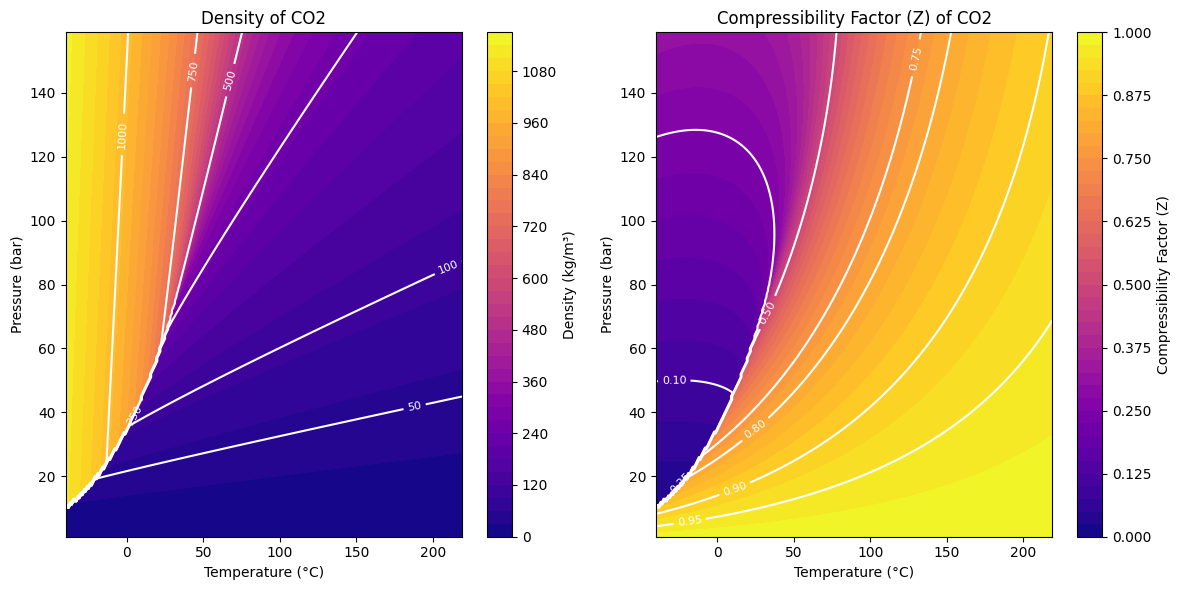

In [ ]:
#@title Density and compressibility of CO

XEEimport CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt

# Define the ranges for temperature and pressure with specified steps
temperatures = np.arange(-40 + 273.15, 200 + 273.15 + 20, 1)  # -40°C to 200°C in Kelvin, steps of 1 K
pressures = np.arange(1, 150 + 10, 1) * 1e5  # 1 bar to 150 bar in Pascals, steps of 1 bar

# Create a grid of temperature and pressure values
T, P = np.meshgrid(temperatures, pressures)

# Calculate densities and compressibility factors
densities = np.vectorize(CP.PropsSI)('D', 'T', T, 'P', P, 'CO2')
Zs = np.vectorize(CP.PropsSI)('Z', 'T', T, 'P', P, 'CO2')

# Create a figure and two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot density on the first subplot (ax1)
contour1 = ax1.contourf(temperatures - 273.15, pressures / 1e5, densities, levels=40, cmap='plasma')
contour_lines1 = ax1.contour(temperatures - 273.15, pressures / 1e5, densities, levels=[50, 100, 250, 500, 750, 1000], colors='white')
ax1.clabel(contour_lines1, inline=True, fontsize=8, fmt='%1.0f')
ax1.set_xlabel("Temperature (°C)")
ax1.set_ylabel("Pressure (bar)")
ax1.set_title("Density of CO2")
cbar1 = fig.colorbar(contour1, ax=ax1)
cbar1.set_label("Density (kg/m³)")

# Plot compressibility factor on the second subplot (ax2)
contour2 = ax2.contourf(temperatures - 273.15, pressures / 1e5, Zs, levels=40, cmap='plasma')
contour_lines2 = ax2.contour(temperatures - 273.15, pressures / 1e5, Zs, levels=[0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 1.0], colors='white')
ax2.clabel(contour_lines2, inline=True, fontsize=8, fmt='%1.2f')
ax2.set_xlabel("Temperature (°C)")
ax2.set_ylabel("Pressure (bar)")
ax2.set_title("Compressibility Factor (Z) of CO2")
cbar2 = fig.colorbar(contour2, ax=ax2)
cbar2.set_label("Compressibility Factor (Z)")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

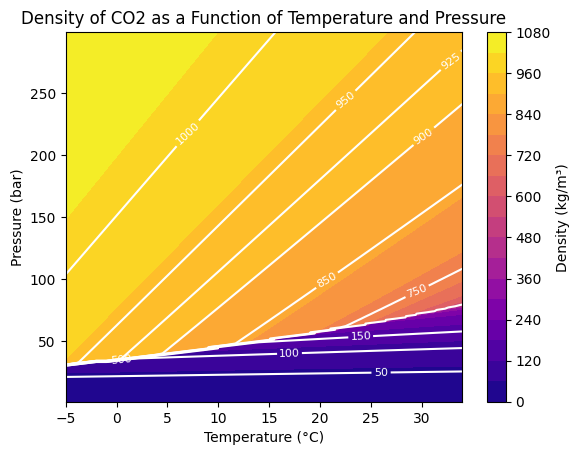

In [ ]:
#@title density zoomed in on P,T

#!pip install CoolProp matplotlib numpy
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt

# Define the ranges for temperature and pressure with specified steps
temperatures = np.arange(-5 + 273.15, 35 + 273.15, 1)  # -40°C to 200°C in Kelvin, steps of 1
pressures = np.arange(1, 300, 1) * 1e5  # 1 bar to 300 bar in Pascals, steps of 1

# Create a grid of temperature and pressure values
T, P = np.meshgrid(temperatures, pressures)

# Calculate densities for each point on the grid
densities = np.vectorize(CP.PropsSI)('D', 'T', T, 'P', P, 'CO2')

# Create a contour plot with 'viridis' colormap
fig, ax = plt.subplots()
contour = ax.contourf(temperatures - 273.15, pressures / 1e5, densities, levels=20, cmap='plasma')

# Add contour lines for specific density values
contour_lines = ax.contour(temperatures - 273.15, pressures / 1e5, densities, levels=[50, 100, 150, 500, 750, 850, 900, 925, 950, 1000], colors='white')
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f') # Label contour lines

# Add labels and title
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Pressure (bar)")
ax.set_title("Density of CO2 as a Function of Temperature and Pressure")

# Add a colorbar
cbar = fig.colorbar(contour)
cbar.set_label("Density (kg/m³)")

# Show the plot
plt.show()

In [ ]:
#@title table of density and mass in reactor
#!pip install ace-tools # Install ace-tools module
!pip install tabulate
import numpy as np
import pandas as pd
from CoolProp.CoolProp import PropsSI
from tabulate import tabulate

# Define temperature and pressure ranges
temperatures = np.arange(0, 181, 10)  # 0 to 170°C in 10°C intervals
pressures = np.arange(5, 111, 10) * 1e5  # 50 to 110 barg in Pa

# Reactor headspace volume
volume_m3 = 1.5  # m³

# Initialize tables
density_table = pd.DataFrame(index=temperatures, columns=pressures / 1e5)
amount_table = pd.DataFrame(index=temperatures, columns=pressures / 1e5)

# Populate tables
for temp in temperatures:
    for pres in pressures:
        try:
            # Get CO2 density in kg/m³
            density = PropsSI('D', 'T', temp + 273.15, 'P', pres, 'CO2')
            density_table.loc[temp, pres / 1e5] = density

            # Calculate mass of CO2 needed to fill reactor
            amount_table.loc[temp, pres / 1e5] = density * volume_m3
        except ValueError:
            # Handle cases where properties are not available
            density_table.loc[temp, pres / 1e5] = None
            amount_table.loc[temp, pres / 1e5] = None

# Convert dataframes to lists for tabulate
density_headers = ["Temp (°C)"] + [f"{p:.0f} barg" for p in pressures / 1e5]
density_table_formatted = [ [temp] + row.tolist() for temp, row in density_table.iterrows() ]

amount_headers = ["Temp (°C)"] + [f"{p:.0f} barg" for p in pressures / 1e5]
amount_table_formatted = [ [temp] + row.tolist() for temp, row in amount_table.iterrows() ]

# Display tables in TSV format
"print("CO2 Density Table (kg/m³):")
"print(tabulate(density_table_formatted, headers=density_headers, tablefmt="tsv"))

print("\nCO2 Amount Table (kg):")
print(tabulate(amount_table_formatted, headers=amount_headers, tablefmt="tsv"))




CO2 Density Table (kg/m³):
  Temp (°C)	0 barg  	  10 barg	  20 barg	  30 barg	  40 barg	  50 barg	  60 barg	  70 barg	  80 barg	  90 barg	  100 barg	  110 barg
          0	        	  20.8367	  45.6078	  77.3353	 932.109 	 940.517 	 948.204 	 955.312 	  961.943	  968.171	   974.051	   979.628
         10	        	  19.9218	  42.9972	  71.0112	 108.412 	 868.631 	 881.784 	 893.107 	  903.133	  912.18 	   920.456	   928.104
         20	        	  19.0985	  40.7727	  66.1557	  97.4916	 140.648 	 782.648 	 808.6   	  827.713	  843.174	   856.31 	   867.814
         30	        	  18.3515	  38.8374	  62.2107	  89.7594	 124.018 	 171.439 	 266.561 	  701.722	  744.309	   771.496	   792.104
         40	        	  17.6692	  37.1275	  58.8916	  83.7577	 113.052 	 149.26  	 198.022 	  277.897	  485.502	   628.612	   683.522
         50	        	  17.0424	  35.5986	  56.0317	  78.8579	 104.846 	 135.208 	 172.015 	  219.183	  284.997	   384.327	   502.644
         60	        	  16.4636	  34.2185	 